In [1]:
import requests
from bs4 import BeautifulSoup
from collections import Counter
import os
import csv
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import re
import math
from textblob import TextBlob as tb
import networkx as nx
# import linkcom
import seaborn as sns
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('partnerwebsites.xls', sheet_name='Sheet1', index_col = 0, header = None)
print(df)

                                                                                                    1
0                                                                                                    
1. Access and Functional Needs                      https://www.phe.gov/Preparedness/planning/abc/...
2. Alternate Care Sites*                            https://asprtracie.hhs.gov/technical-resources...
3. Ambulatory Care and Federally Qualified Heal...  https://asprtracie.hhs.gov/technical-resources...
4. Bioterrorism                                     https://www.aap.org/en-us/advocacy-and-policy/...
5. Blood and Blood Products                         https://asprtracie.hhs.gov/technical-resources...
6. Burns                                            https://asprtracie.hhs.gov/technical-resources...
7. Chemical Hazards                                 https://asprtracie.hhs.gov/technical-resources...
8. Coalition Administrative Issues                  https://asprtracie.hhs.gov/tec

In [3]:
def findlinks(html2):
    while True:
        try:
           r = requests.get(html2, allow_redirects=True,timeout = (2, 5))
           r.raise_for_status()
        except requests.exceptions.RequestException as e: 
           return"" 
        if r.status_code == 200:
            break # Exit loop if status is valid
        else:
            return ""
        #except HTTPError as http_err:
            #print(f'HTTP error occurred: {http_err}')  # Python 3.6
            #return""
        #except Exception as err:
            #print(f'Other error occurred: {err}')  # Python 3.6
            #return"" 
    sitelinks =[]
    soup = BeautifulSoup(r.text, 'html.parser')
    
    foundUrls = Counter([link["href"] for link in soup.find_all("a", href=lambda href: href and href.startswith("h"))])
    foundUrls = foundUrls.most_common()
    for item in foundUrls:
        #print ("%s: %d" % (item[0], item[1]))
        sitelinks.append(item[0])
    return sitelinks

In [4]:
from requests.exceptions import HTTPError
def cleanMe2(html):
    try:
        #first element being a connect timeout and the second being a read timeout
        r = requests.get(html, allow_redirects = True,timeout = (2, 5))
        # If the response was successful, no Exception will be raised
        r.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')  # Python 3.6
    except Exception as err:
        print(f'Other error occurred: {err}')  # Python 3.6
        return"" 
    #else:
        #print('Success!')
    soup = BeautifulSoup(r.content, 'lxml')
    
    for script in soup(["script", "style"]): # remove all javascript and stylesheet code
        script.extract()
    # get text
    text = soup.get_text()
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())   
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text 

In [5]:
def wordsToList(strn):
    L = strn.split()
    cleanL = []
    abc = 'abcdefghijklmnopqrstuvwxyz'
    ABC = abc.upper()
    letters = abc + ABC
    for e in L:
        word = ''
        for c in e:
            if c in letters:
                word += c
        if word != '':
            cleanL.append(word.lower())
    return cleanL

In [6]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

In [7]:
wordcount_df = pd.DataFrame(index = np.arange(3000), columns = ['Org', 'Word'])
#words = []
#word_list = []
count = 0
# For every partner/child website in the parent/CEC dataframe  
for i in df.index:
    # start with a clean list of words
    #del words[:]
    #del word_list[:]
    words = []
    word_list = []
    txt = "" 
    
    # find the links within the partner website
    partnerlinks = findlinks(df[1][i])
    print(i)  # track script progress
    
    # get the text from every link in the partner's website 
    for y in partnerlinks:
        txt += cleanMe2(y)
    
    # convert the text into words and subtract the common words
    words = wordsToList(txt)
    common_words = ('and','a', 'the', 'from', 'in', 'an', 'of', 'to', 'is', 
                    'for', 'that', 'has', 'on', 'you', 'your', 'youre', 
                    'are', 'or', 'as', 'at', 'by', 'about', 'this',
                    'be', 'other', 'home', 'their', 'up', 'its',
                    'our', 'information', 'twitter', 'undo', 'with', 'us', 'we', 'new', 'close', 'use', 
                    'all', 'more', 'will', 'tweet', 'https', 'n', 'r', 'f', 'image', 'q',
                    'than','was', 'he', 'she', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 
                    'sep', 'oct', 'nov', 'dec', 'i', 'retweet', 'retweeted', 'were', 'but', 'opens',
                    'have', 'play', 'nextplay', 'search', 'ago', 'duragettion', 'views', 'seconds', 'can' ,'it',
                    'get', 'th', 'fax', 'de', 'tge', 'fh', 'w', 'u' , 'into'
                   )

    words = [x for x in words if x not in common_words]
    #words [y for y in words if y not in stopwords.words()]  #requires: from nltk.corpus import stopwords
    
    # count the words and make a list of the most common words
    word_list = Counter(words)
    word_list = word_list.most_common(200) 
    #print(word_list)

    word_text = ""
    for word, nbr in word_list:
        word_text += word
        word_text += " "
    
    wordcount_df["Word"][count]= word_text
    wordcount_df["Org"][count]= i
    count +=1
    
#drop the values at the end of the table and print
wordcount_df = wordcount_df.dropna()
print(count)
wordcount_df.set_index("Org")
print(wordcount_df)

1. Access and Functional Needs 
Other error occurred: HTTPConnectionPool(host='www.bt.cdc.gov', port=80): Max retries exceeded with url: /workbook/pdf/ph_workbookFINAL.pdf (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1319c0610>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
HTTP error occurred: 404 Client Error: Not Found for url: https://www.fema.gov/media-library-data/20130726-1819-25045-9288/ndhs_core.pdf
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.fcc.gov/general/emergency-alert-system-eas
HTTP error occurred: 404 Client Error: Not Found for url: https://www.fema.gov/about/stafact.shtm
Other error occurred: HTTPConnectionPool(host='section508.gov', port=80): Max retries exceeded with url: /Section-508-Of-The-Rehabilitation-Act (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x131f9b130>, 'Connection to section508.gov timed out. (connect timeout=2)

HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5818807/
Other error occurred: HTTPConnectionPool(host='www.militaryblood.dod.mil', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x131f7ddf0>, 'Connection to www.militaryblood.dod.mil timed out. (connect timeout=2)'))
HTTP error occurred: 429 Client Error: - for url: https://www.instagram.com/accounts/login/
6. Burns 
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.sciencedirect.com/science/article/pii/S0305417911003263
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3319312/
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3778650/
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3255093/
HTTP error occurred: 403 Client Error: Fo

HTTP error occurred: 404 Client Error: Not Found for url: https://www.osha.gov/sites/default/files/publications/OSHA3114/OSHA-3114-hazwoper.pdf
HTTP error occurred: 403 Client Error: Forbidden for url: https://teex.org/Pages/Class.aspx?course=AWR160&courseTitle=WMD/Terrorism+Awareness+for+Emergency+Responders
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3951639/
HTTP error occurred: 403 Client Error: Forbidden for url: https://jamanetwork.com/journals/jama/article-abstract/197016
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.sciencedirect.com/science/book/9780128001592
Other error occurred: HTTPConnectionPool(host='ccc.apgea.army.mil', port=80): Max retries exceeded with url: /default.htm (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x131de3760>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
HTTP error occurred: 403 Client Er

HTTP error occurred: 403 Client Error: Forbidden for url: https://onlinelibrary.wiley.com/doi/10.1197/j.aem.2005.07.037/epdf
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2629638/
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4849534/
Other error occurred: HTTPSConnectionPool(host='www.cambridge.org', port=443): Read timed out. (read timeout=5)
HTTP error occurred: 429 Client Error: - for url: https://www.instagram.com/accounts/login/
14. Cybersecurity 
HTTP error occurred: 404 Client Error: Not Found for url: https://www.sans.org/white-papers/34735/
HTTP error occurred: 403 Client Error: Forbidden for url: https://healthsectorcouncil.org/hscc-recommendations/
Other error occurred: HTTPSConnectionPool(host='www.infragard.org', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify fail

HTTP error occurred: 403 Client Error: Forbidden for url: https://www.hcinnovationgroup.com/cybersecurity/disaster-recovery-business-continuity/article/13021926/be-prepared-lessons-from-an-extended-outage-of-a-hospitals-ehr-system
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4134444/
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3000757/
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.sciencedirect.com/science/article/pii/S0196064414005198
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900146/
HTTP error occurred: 403 Client Error: Forbidden for url: https://academic.oup.com/jamia/article/9/2/97/753315?login=true
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1854987/
HTTP error occurred: 405 Client Error: Forbidden for url: https://www.wir

In [8]:
wordcount_df = wordcount_df.drop(wordcount_df[wordcount_df.Word == ''].index)
print(wordcount_df)
wordcount_df.to_excel("wordcount_df.xlsx")

                                                  Org  \
0                     1. Access and Functional Needs    
1                           2. Alternate Care Sites*    
2   3. Ambulatory Care and Federally Qualified Hea...   
3                                    4. Bioterrorism    
4                        5. Blood and Blood Products    
5                                           6. Burns    
6                                7. Chemical Hazards    
7                 8. Coalition Administrative Issues    
8                  9. Coalition Models and Functions    
9                  10. Coalition Response Operations    
10                         11. Communication Systems    
11        12. Continuity of Operations/ Failure Plan    
12                     13. Crisis Standards of Care*    
13                                 14. Cybersecurity    
14                             15. Dialysis Centers*    
15                              16. Disaster Ethics*    
16                             

In [54]:
#for reading from spreadsheet
wordcount_df = pd.read_excel('wordcount_df.xls', sheet_name='Sheet1')

In [9]:
docs = wordcount_df['Word'].tolist()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(analyzer='word')
tfidf_matrix = vect.fit_transform(docs)
tf_idf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names(), index = wordcount_df['Org'])
print(tf_idf_df)

                                                        aabb       aap  \
Org                                                                      
1. Access and Functional Needs                      0.000000  0.000000   
2. Alternate Care Sites*                            0.000000  0.000000   
3. Ambulatory Care and Federally Qualified Heal...  0.000000  0.000000   
4. Bioterrorism                                     0.000000  0.096425   
5. Blood and Blood Products                         0.116941  0.000000   
6. Burns                                            0.000000  0.000000   
7. Chemical Hazards                                 0.000000  0.000000   
8. Coalition Administrative Issues                  0.000000  0.000000   
9. Coalition Models and Functions                   0.000000  0.000000   
10. Coalition Response Operations                   0.000000  0.000000   
11. Communication Systems                           0.000000  0.000000   
12. Continuity of Operations/ Failure 

In [11]:
#for import into Gephi using spreadsheet matrix input
tf_idf_df.to_excel("all3matrix_idf_df.xlsx")


In [12]:
def cosine_similarity(vector1, vector2):
    dot_product = sum(p*q for p,q in zip(vector1, vector2))
    magnitude = math.sqrt(sum([val**2 for val in vector1])) * math.sqrt(sum([val**2 for val in vector2]))
    if not magnitude:
        return 0
    return dot_product/magnitude

In [13]:
cos_sim1 = cosine_similarity(tf_idf_df.iloc[0], tf_idf_df.iloc[1])
cos_sim2 = cosine_similarity(tf_idf_df.iloc[0], tf_idf_df.iloc[2])
cos_sim3 = cosine_similarity(tf_idf_df.iloc[0], tf_idf_df.iloc[3])
print(wordcount_df)
print(cos_sim1, cos_sim2, cos_sim3)

                                                  Org  \
0                     1. Access and Functional Needs    
1                           2. Alternate Care Sites*    
2   3. Ambulatory Care and Federally Qualified Hea...   
3                                    4. Bioterrorism    
4                        5. Blood and Blood Products    
5                                           6. Burns    
6                                7. Chemical Hazards    
7                 8. Coalition Administrative Issues    
8                  9. Coalition Models and Functions    
9                  10. Coalition Response Operations    
10                         11. Communication Systems    
11        12. Continuity of Operations/ Failure Plan    
12                     13. Crisis Standards of Care*    
13                                 14. Cybersecurity    
14                             15. Dialysis Centers*    
15                              16. Disaster Ethics*    
16                             

In [14]:
len(tf_idf_df)

18

In [15]:
c = 0
n2=0
ln = len(tf_idf_df)
col_names =  ['source_org','target_org','cos_sim']
df_cos = pd.DataFrame(columns = col_names)
for index, rows in tf_idf_df.iterrows():
    n=0
    while c < ln and n+1 < ln:
        cos_sim = cosine_similarity(tf_idf_df.loc[index], tf_idf_df.iloc[n+1])
        #df_cos.loc[n2]=[index, c, n+1, round(cos_sim,3)]
        df_cos.loc[n2]=[index, tf_idf_df.index[n+1], round(cos_sim,3)]
        n+=1
        n2+=1
    c+=1
print(df_cos.loc[df_cos['cos_sim']<1].sort_values(by=['cos_sim'], ascending = False))

                                            source_org  \
126                8. Coalition Administrative Issues    
142                 9. Coalition Models and Functions    
144                 9. Coalition Models and Functions    
160                 10. Coalition Response Operations    
127                8. Coalition Administrative Issues    
..                                                 ...   
2                      1. Access and Functional Needs    
3                      1. Access and Functional Needs    
86                                           6. Burns    
38   3. Ambulatory Care and Federally Qualified Hea...   
4                      1. Access and Functional Needs    

                                            target_org  cos_sim  
126                 9. Coalition Models and Functions     0.614  
142                8. Coalition Administrative Issues     0.614  
144                 10. Coalition Response Operations     0.608  
160                 9. Coalition Models

In [16]:
print(df_cos.loc[df_cos['cos_sim']<1].sort_values(by=['cos_sim'], ascending = False))

                                            source_org  \
126                8. Coalition Administrative Issues    
142                 9. Coalition Models and Functions    
144                 9. Coalition Models and Functions    
160                 10. Coalition Response Operations    
127                8. Coalition Administrative Issues    
..                                                 ...   
2                      1. Access and Functional Needs    
3                      1. Access and Functional Needs    
86                                           6. Burns    
38   3. Ambulatory Care and Federally Qualified Hea...   
4                      1. Access and Functional Needs    

                                            target_org  cos_sim  
126                 9. Coalition Models and Functions     0.614  
142                8. Coalition Administrative Issues     0.614  
144                 10. Coalition Response Operations     0.608  
160                 9. Coalition Models

In [17]:
s_org = 'nato'
s_data = df_cos.loc[df_cos['source_org']==s_org].sort_values(by=['cos_sim'], ascending = False)
s_data = s_data[1:11]
print(s_data[0:5].sort_values(by=['cos_sim'], ascending = False))

Empty DataFrame
Columns: [source_org, target_org, cos_sim]
Index: []


[Text(-0.06, 0, ''),
 Text(-0.039999999999999994, 0, ''),
 Text(-0.019999999999999997, 0, ''),
 Text(0.0, 0, ''),
 Text(0.020000000000000004, 0, ''),
 Text(0.04000000000000001, 0, ''),
 Text(0.06, 0, '')]

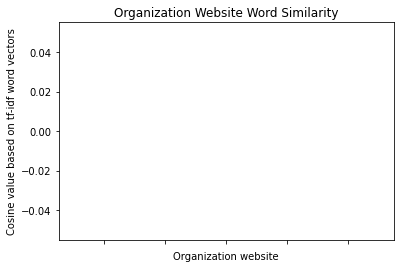

In [18]:
fig, ax = plt.subplots()
plt.bar(s_data['target_org'], s_data['cos_sim'])

plt.title("Organization Website Word Similarity")
plt.ylabel("Cosine value based on tf-idf word vectors")
plt.xlabel("Organization website")
#ax.xticks(np.arange(12), target_org, rotation=90)
#ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(s_data["target_org"], rotation = 90)

In [19]:
print(df_cos.loc[df_cos['source_org']=='ctil'].sort_values(by=['cos_sim'], ascending = False))

Empty DataFrame
Columns: [source_org, target_org, cos_sim]
Index: []


In [20]:
c =0
n=0
ln = len(tf_idf_df)
col_names =  ['source_org','target_word','source', 'target', 'tf_idf']
df_tfidf = pd.DataFrame(columns = col_names)
for col in tf_idf_df:
    for indx, rws in tf_idf_df.iterrows():
        if rws[col] > 0:
            df_tfidf.loc[n]=[indx, col, c, n, rws[col]]
            n+=1
    c+=1    
print(df_tfidf.sort_values(by=['tf_idf']))

                          source_org       target_word source target    tf_idf
927                 4. Bioterrorism             during    256    927  0.029657
1787                4. Bioterrorism            medical    498   1787  0.029657
2629                4. Bioterrorism           response    697   2629  0.029657
2993                4. Bioterrorism            support    790   2993  0.029657
3421                4. Bioterrorism              which    906   3421  0.029657
...                              ...               ...    ...    ...       ...
2163  17. Electronic Health Records               pdmp    587   2163  0.131352
1566  17. Electronic Health Records   interoperability    432   1566  0.131352
967   17. Electronic Health Records               ehrs    270    967  0.131352
3077  17. Electronic Health Records       telemedicine    813   3077  0.131352
2056  17. Electronic Health Records             opioid    562   2056  0.131352

[3478 rows x 5 columns]


In [21]:
print(df_tfidf.sort_values(by=['tf_idf']))

                          source_org       target_word source target    tf_idf
927                 4. Bioterrorism             during    256    927  0.029657
1787                4. Bioterrorism            medical    498   1787  0.029657
2629                4. Bioterrorism           response    697   2629  0.029657
2993                4. Bioterrorism            support    790   2993  0.029657
3421                4. Bioterrorism              which    906   3421  0.029657
...                              ...               ...    ...    ...       ...
2163  17. Electronic Health Records               pdmp    587   2163  0.131352
1566  17. Electronic Health Records   interoperability    432   1566  0.131352
967   17. Electronic Health Records               ehrs    270    967  0.131352
3077  17. Electronic Health Records       telemedicine    813   3077  0.131352
2056  17. Electronic Health Records             opioid    562   2056  0.131352

[3478 rows x 5 columns]


In [22]:
df_cos.to_excel("CTILcomparecos.xlsx") 
wordcount_df.to_excel("CTILwordcount_df.xlsx")
tf_idf_df.to_excel("CTIL_matrix_tf_idf_df.xlsx")
df_tfidf.to_excel("CTIL_df_tfidf.xlsx")

In [23]:
cosine_graph = nx.Graph()
for idx,row in df_cos.iterrows():
    a = row["source_org"]
    b = row["target_org"]
    c = row["cos_sim"]
    cosine_graph.add_edge(a,str(b), weight = c)
G = cosine_graph  

In [24]:
tf_idf_graph = nx.Graph()
for idx,row in df_tfidf.iterrows():
    a = row["source_org"]
    b = row["target_word"]
    c = row["tf_idf"]
    tf_idf_graph.add_edge(a,b, weight = c)
G2 = tf_idf_graph   

In [25]:
e2c, S, D, Dlist = linkcom.cluster(G)
nx.set_edge_attributes(G, e2c, "linkcom")
nx.write_gexf(G, "cecpartcosine_graph.gexf")
print(nx.info(G))

NameError: name 'linkcom' is not defined

In [26]:
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
txt_fitted = tf.fit(docs)
txt_transformed = txt_fitted.transform(docs)
#print ("The text: ", docs)

[Text(19.4, 0, '19'), Text(17.4, 0, '17')]

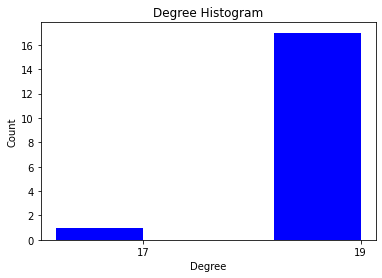

In [27]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

In [28]:
tf.vocabulary_

{'people': 592,
 'emergency': 275,
 'disabilities': 231,
 'who': 909,
 'shelter': 744,
 'assistance': 61,
 'disaster': 233,
 'provide': 653,
 'needs': 533,
 'services': 736,
 'shelters': 745,
 'state': 776,
 'health': 366,
 'ensure': 279,
 'government': 351,
 'procedures': 638,
 'management': 484,
 'ada': 18,
 'disability': 232,
 'not': 546,
 'accessible': 9,
 'local': 476,
 'federal': 320,
 'medical': 498,
 'no': 543,
 'resources': 692,
 'programs': 644,
 'policies': 611,
 'such': 784,
 'care': 103,
 'help': 370,
 'fema': 321,
 'individuals': 413,
 'act': 13,
 'housing': 388,
 'preparedness': 624,
 'need': 531,
 'access': 6,
 'public': 658,
 'planning': 603,
 'how': 389,
 'service': 735,
 'if': 396,
 'yes': 920,
 'policy': 612,
 'including': 409,
 'insurance': 425,
 'rand': 664,
 'national': 527,
 'any': 49,
 'sec': 724,
 'facilities': 310,
 'issues': 436,
 'disasters': 234,
 'administrator': 23,
 'they': 826,
 'plan': 602,
 'requires': 686,
 'special': 770,
 'response': 697,
 'plans'

In [29]:
idf = tf.idf_
print(dict(zip(txt_fitted.get_feature_names(), idf)))

{'aabb': 3.8903717578961645, 'aap': 3.8903717578961645, 'aaporg': 3.8903717578961645, 'abstract': 1.587786664902119, 'academies': 3.8903717578961645, 'academy': 3.8903717578961645, 'access': 1.0, 'accessed': 3.8903717578961645, 'accessibility': 2.504077396776274, 'accessible': 3.1972245773362196, 'account': 2.504077396776274, 'across': 3.1972245773362196, 'acs': 3.8903717578961645, 'act': 1.587786664902119, 'actions': 1.587786664902119, 'activities': 2.504077396776274, 'acute': 2.791759469228055, 'ad': 3.8903717578961645, 'ada': 3.1972245773362196, 'add': 1.4054651081081644, 'additional': 2.09861228866811, 'address': 2.09861228866811, 'administration': 2.09861228866811, 'administrator': 3.1972245773362196, 'adobe': 2.791759469228055, 'advance': 3.8903717578961645, 'advanced': 2.504077396776274, 'advice': 3.8903717578961645, 'advocacy': 3.8903717578961645, 'affected': 3.8903717578961645, 'after': 1.0571584138399486, 'against': 3.8903717578961645, 'agencies': 1.9444616088408515, 'agency'

In [30]:
rr = dict(zip(txt_fitted.get_feature_names(), idf))

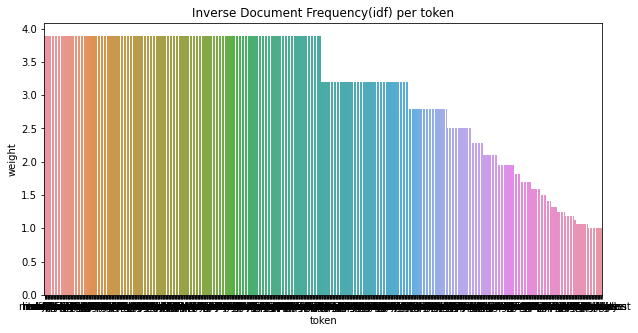

In [31]:


token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight 

sns.barplot(x='token', y='weight', data=token_weight)            
plt.title("Inverse Document Frequency(idf) per token")
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.show()


In [32]:
# get feature names
feature_names = np.array(tf.get_feature_names())
sorted_by_idf = np.argsort(tf.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['help' 'national' 'medical' 'resources' 'during' 'public' 'when'
 'response' 'such' 'which']

Features with highest idf:
['herndon' 'high' 'hipaa' 'hoc' 'homeland' 'hospice' 'hospices' 'hours'
 'hhas' 'york']


In [33]:
new1 = tf.transform(docs)

# find maximum value for each of the features over all of dataset:
max_val = new1.max(axis=0).toarray().ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sort_by_tfidf[:10]]))

print("\nFeatures with highest tfidf: \n{}".format(
      feature_names[sort_by_tfidf[-10:]]))

Features with lowest tfidf:
['help' 'national' 'medical' 'resources' 'during' 'public' 'when'
 'response' 'such' 'which']

Features with highest tfidf: 
['herndon' 'high' 'hipaa' 'hoc' 'homeland' 'hospice' 'hospices' 'hours'
 'hhas' 'york']


In [34]:


def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [35]:
shortest_paths = nx.shortest_path(G2)
print(shortest_paths['network']['family'])

['network', '10. Coalition Response Operations\xa0', 'access', '4. Bioterrorism\xa0', 'family']


In [36]:
# convert the text to a tf-idf weighted term-document matrix
vectorizer = TfidfVectorizer(max_features=3000, min_df=4, stop_words='english')
X = vectorizer.fit_transform(docs)
idx_to_word = np.array(vectorizer.get_feature_names())

In [61]:
# apply NMF
nmf = NMF(n_components=10, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_

In [62]:
for i, topic in enumerate(H):
 
    print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: federal, safety, program, privacy, infrastructure, technology, aspr, incident, security, service
Topic 2: abstract, options, format, items, create, pmc, mesh, summary, pmid, free
Topic 3: framework, comments, login, item, rate, favorite, doesnt, openclose, toggle, comment
Topic 4: specific, assistant, needs, coronavirus, regional, cms, nursing, members, important, behavioral
Topic 5: policies, view, website, questions, activities, water, members, key, quality, news
Topic 6: government, technical, issues, questions, learn, website, plain, accessibility, topics, social
Topic 7: communication, facility, agencies, address, plans, individuals, business, needs, include, emergencies
Topic 8: water, crossref, network, terms, number, hurricane, area, cms, scopus, facility
Topic 9: important, view, process, saved, work, journal, crisis, social, personal, based
Topic 10: event, used, equipment, google, events, development, triage, american, guidelines, crossref


In [39]:
from itertools import combinations

In [40]:
def sorted_shortest_path_lengths(G):
    c= combinations(nx.nodes(G), 2)
    path_list = []
    spl = 0
    for n in c:
        try:
            spl = nx.shortest_path_length(G, source=n[0], target=n[1], weight=None)
        except:
            pass
        if spl >= 0:
            path_list.append(spl)
        #print(n)   
    psort = sorted(path_list)
    return psort

In [41]:
short_path_length = sorted_shortest_path_lengths(G2)
#print(short_path_length)

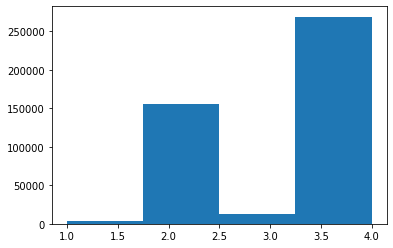

In [42]:
rvs = short_path_length
#print(rvs)
#plot histogram
pdf, bins, patch = plt.hist(rvs, bins=4)

In [43]:
print(G2['education'])

{'4. Bioterrorism\xa0': {'weight': 0.07586811646007262}, '13. Crisis Standards of Care*\xa0': {'weight': 0.09577196180107599}, '15. Dialysis Centers*\xa0': {'weight': 0.09188400427429289}}


In [44]:
print(G2['fire'])

{'3. Ambulatory Care and Federally Qualified Health Centers*\xa0': {'weight': 0.10678785084618694}}


In [45]:
print(G2['disaster'])

{'1. Access and Functional Needs\xa0': {'weight': 0.032490519494316986}, '2. Alternate Care Sites*\xa0': {'weight': 0.0399958929585347}, '3. Ambulatory Care and Federally Qualified Health Centers*\xa0': {'weight': 0.03462056935495881}, '4. Bioterrorism\xa0': {'weight': 0.03126097490185882}, '5. Blood and Blood Products\xa0': {'weight': 0.03791224018162542}, '6. Burns\xa0': {'weight': 0.03491419397377641}, '7. Chemical Hazards\xa0': {'weight': 0.03772444302207424}, '8. Coalition Administrative Issues\xa0': {'weight': 0.0423767131316011}, '9. Coalition Models and Functions\xa0': {'weight': 0.04539975448512966}, '10. Coalition Response Operations\xa0': {'weight': 0.040035228962848085}, '11. Communication Systems\xa0': {'weight': 0.03740639322672103}, '12. Continuity of Operations/ Failure Plan\xa0': {'weight': 0.040337372759993904}, '13. Crisis Standards of Care*\xa0': {'weight': 0.03946222779553044}, '15. Dialysis Centers*\xa0': {'weight': 0.0378602196221995}, '16. Disaster Ethics*\xa0':

In [46]:
print(G2['data'])

{'2. Alternate Care Sites*\xa0': {'weight': 0.04216473167725245}, '3. Ambulatory Care and Federally Qualified Health Centers*\xa0': {'weight': 0.036497922896206986}, '5. Blood and Blood Products\xa0': {'weight': 0.03996808962857946}, '6. Burns\xa0': {'weight': 0.03680746976090919}, '7. Chemical Hazards\xa0': {'weight': 0.03977010887964519}, '8. Coalition Administrative Issues\xa0': {'weight': 0.04467465548050919}, '9. Coalition Models and Functions\xa0': {'weight': 0.047861625894019356}, '10. Coalition Response Operations\xa0': {'weight': 0.04220620073680936}, '11. Communication Systems\xa0': {'weight': 0.03943481234569915}, '12. Continuity of Operations/ Failure Plan\xa0': {'weight': 0.04252472874536783}, '13. Crisis Standards of Care*\xa0': {'weight': 0.041602127701216705}, '14. Cybersecurity\xa0': {'weight': 0.036925467852382744}, '15. Dialysis Centers*\xa0': {'weight': 0.039913248174428935}, '16. Disaster Ethics*\xa0': {'weight': 0.04185545284627186}, '16b. DisasterEthics2': {'weig

In [49]:
print(nx.dijkstra_path(G2, "disaster", "school"))

['disaster', '7. Chemical Hazards\xa0', 'school']


In [50]:
print(nx.dijkstra_path(G2, "network", "family"))

['network', '14. Cybersecurity\xa0', 'access', '4. Bioterrorism\xa0', 'family']


In [52]:
print(nx.shortest_path(G2, "disaster", "school"))

['disaster', '7. Chemical Hazards\xa0', 'school']


In [53]:
print(nx.shortest_path(G2, "network", "family"))

['network', '10. Coalition Response Operations\xa0', 'access', '4. Bioterrorism\xa0', 'family']


In [54]:
print(G2['family'])

{'4. Bioterrorism\xa0': {'weight': 0.09642511337405084}}


In [55]:
print(G2['network'])

{'10. Coalition Response Operations\xa0': {'weight': 0.08868723023420319}, '11. Communication Systems\xa0': {'weight': 0.08286375510448295}, '14. Cybersecurity\xa0': {'weight': 0.07759090872336834}, '15. Dialysis Centers*\xa0': {'weight': 0.08386908483694203}}


AttributeError: module 'networkx' has no attribute 'connected_component_subgraphs'

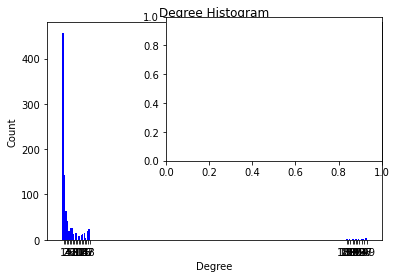

In [56]:
G= G2

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=1)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()

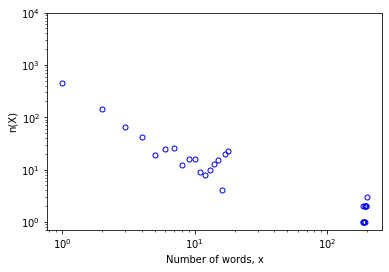

In [57]:
plt.ylim((0.7, 10000)) # more clearly show the points at the bottom. 
plt.xlabel('Number of words, x')
plt.ylabel("n(X)")
plt.loglog(deg,cnt, 'bo', markersize=5, markerfacecolor='none')

In [58]:
print(nx.average_clustering(G2, nodes=None, weight=None, count_zeros=True))

0.0


In [59]:
print("Average shortest path length:",round(nx.average_shortest_path_length(G2),1))
print("Average clustering coefficient:", round(nx.average_clustering(G2),3))

Average shortest path length: 3.2
Average clustering coefficient: 0.0


In [60]:
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 940
Number of edges: 3478
Average degree:   7.4000
